> Required Imports

In [1]:
from os import remove, scandir
import pandas as pd
import matplotlib.pyplot as plt
from gtts import gTTS
from wonderwords import RandomSentence
import librosa
import numpy as np
from os.path import exists
from config import CONFIG

> Generate Google Assistant Voice Samples

In [2]:
language = 'en'
google_filepath = CONFIG.get("files", "google_filepath")

if exists(google_filepath):
    pass
else:
    for i in range(200):
        s = RandomSentence()
        s = s.sentence().lower().strip("the .") + " " + s.sentence().lower().strip("the .") + " " + s.sentence().lower().strip("the ")
        tts = gTTS(text=s, lang=language, slow=False) 
        tts.save(google_filepath + "temp.wav")

        y, sr = librosa.load(google_filepath + "temp.wav")
        y = y + max(y)*0.002*np.random.normal(-1, 1, len(y))
        librosa.audio.sf.write(google_filepath + f"{i:05d}.wav", y, sr)
    remove(google_filepath + "temp.wav")

> Visualize Number of samples for each speaker

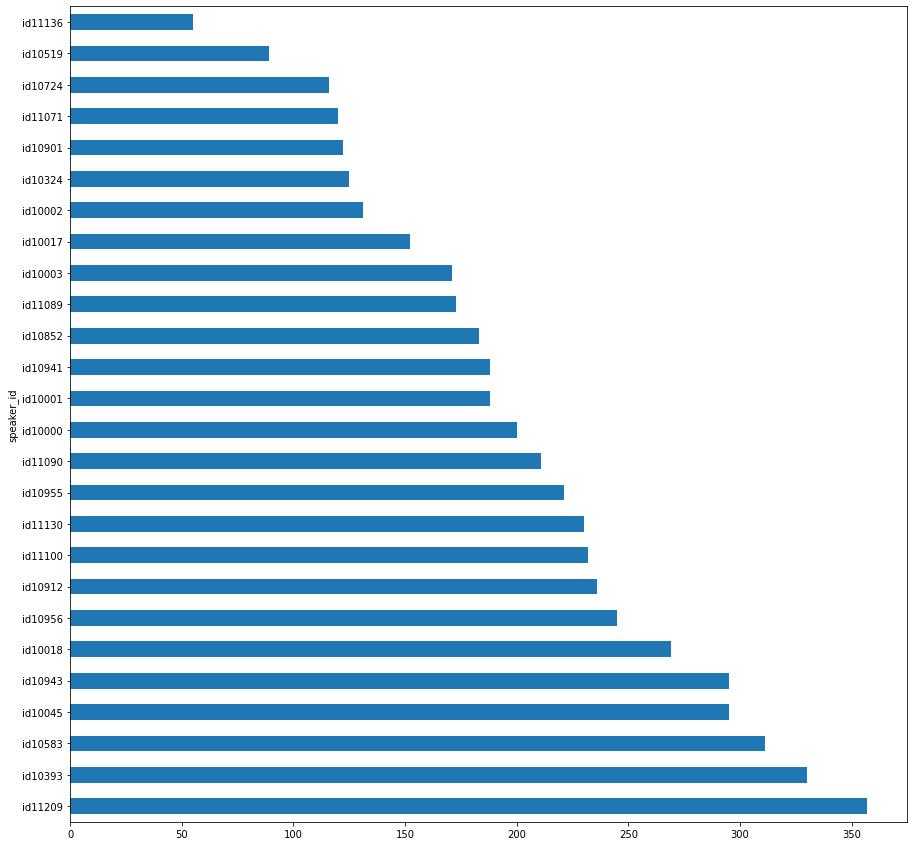

In [3]:
df = pd.DataFrame([], columns=["speaker_id", "filepath"])
root = CONFIG.get("files", "audio_root")
for x in scandir(root):
    if x.is_dir():
        for y in scandir(x):
            for z in scandir(y):
                df.loc[len(df)] = [x.name, z.path]

df.value_counts("speaker_id").plot(kind="barh", figsize=(15,15))
plt.show()

> Undersample Classes (Speakers) with more than 200 samples

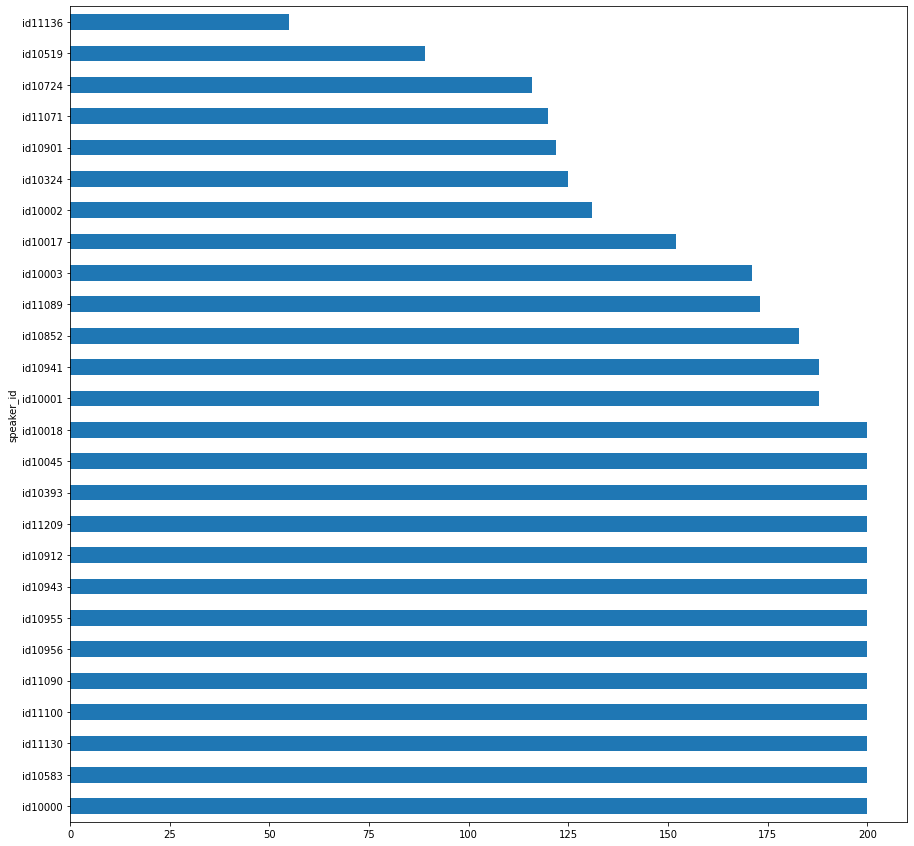

In [4]:
grps = df.groupby("speaker_id")
df = pd.DataFrame([], columns=["speaker_id", "filepath"])
for x, y in grps:
    df = pd.concat([df, y.sample(frac=1)[:200]], ignore_index=True)

df.value_counts("speaker_id").plot(kind="barh", figsize=(15,15))
plt.show()

> Save the dataframe for training

In [5]:
df.to_csv(CONFIG.get("files", "base_data"), index=False)